# IPython Notebook Validation for py.test - Documentation

One of the powerful uses of the IPython notebook is for documentation purposes, here we use a notebook to demonstrate the behaviour and usage of the IPython Notebook Validation plugin for py.test. The IPython notebook format `.ipynb` stores outputs as well as inputs. Validating the notebook means to rerun the notebook and make sure that it is generating the same output as has been stored.

Therefore, the **user MUST make the following the distinction**:

1. Running a notebook manually will likely change the output stored in the associated .ipynb file. These outputs will be used as references for the tests (i.e. the outputs from the last time you ran the notebook)
2. Validating with py.test plugin - these tests run your notebook code seperately without storing the information, the outputs generated will be compared against those in the .ipynb file

The purpose of the testing module is to ensure that the notebook is behaving as expected and that changes to underlying source code, haven't affected the results of an IPython notebook. For example, for documentation purposes - such as this.

### Command line usage

The py.test program doesn't usually collect notebooks for testing; by passing the `--nbval` flag at the command line, the IPython Notebook Validation plugin will collect and test notebook cells, comparing their outputs with those saved in the file.

```
$ py.test --nbval my_notebook.ipynb
```

There is also an option `--nbval-lax`, which collects notebooks and runs them, failing if there is an error. This mode does not check the output of cells unless they are marked with a special `#NBVAL_CHECK_OUTPUT` comment.

```
$ py.test --nbval-lax my_notebook.ipynb
```

### REGEX Output sanitizing

Since all output is captured by the IPython notebook, some pesky messages and prompts (with time-stamped messages, for example) may fail tests always, which might be expected. The plugin allows the user to specify a sanitizing file at the command prompt using the following flag:
```
$ py.test --nbval my_notebook.ipynb --sanitize-with my_sanitize_file
```

This sanitize file contains a number of REGEX replacements. It is recommended, when removing output for the tests, that you replace the removed output with some sort of marker, this helps with debugging. The following file is written to the folder of this notebook and can be used to sanitize its outputs:

In [1]:
%%writefile doc_sanitize.cfg
[regex1]
regex: \d{1,2}/\d{1,2}/\d{2,4}
replace: DATE-STAMP

[regex2]
regex: \d{2}:\d{2}:\d{2}
replace: TIME-STAMP

Writing doc_sanitize.cfg


The first replacement finds dates in the given format replaces them with the label 'DATE-STAMP', likewise for strings that look like time. These will prevent the tests from failing due to time differences.

### Validate this notebook

This documentation is written as a Notebook. You can validate this notebook yourself, as shown below; the outputs that you see here are stored in the ipynb file. If your system produces different outputs, the testing process will fail. Just use the following commands:
```
$ cd /path/to/repo/docs/source
$ py.test --nbval index.ipynb --sanitize-with doc_sanitize.cfg
```

### Examples of plugin behaviour

The following examples demonstrate how the plugin behaves during testing. Test this notebook yourself to see the validation in action!

These two imports produce no output as standard, if any **warnings** are printed out the cell will fail. Under normal operating conditions they will pass.

In [2]:
import numpy as np
import time

If python doesn't consistently print 7, then something has gone terribly wrong. **Deterministic cells** are expected to pass everytime

In [3]:
print(5+2)

7


**Random outputs** will always fail.

In [4]:
print([np.random.rand() for i in range(4)])
print([np.random.rand() for i in range(4)])

[0.36133679016382714, 0.5043774697891126, 0.23281910875007927, 0.2713065513128683]
[0.5512421277985322, 0.02592706358897756, 0.05036036771084684, 0.7515926759190724]


**Inconsistent number of lines** of output will cause an error to be thrown.

In [5]:
for i in range(np.random.randint(1, 8)):
    print(1)

1
1
1


Because the **time and date** will change with each run, we would expect this cell to fail everytime. Using the sanitize file `doc_sanitize.cfg` (created above) you can clean up these outputs.

In [6]:
print('The time is: ' + time.strftime('%H:%M:%S'))
print("Today's date is: " + time.strftime('%d/%m/%y'))

The time is: 15:28:30
Today's date is: 21/12/16


### Avoid output comparison for specific cells

In case we want to avoid the testing process in specific input cells, we can write the comment ** #NBVAL_IGNORE_OUTPUT ** at the
beginning of the them:

In [7]:
# NBVAL_IGNORE_OUTPUT
print('This is not going to be tested')
print(np.random.randint(1, 20000))

This is not going to be tested
12544


There's also a counterpart, to ensure the output is tested even when using `--nbval-lax` :

In [8]:
# NBVAL_CHECK_OUTPUT
print("This will be tested")
print(6 * 7)

This will be tested
42


Note that unexecuted cells will always skip its output check:

In [ ]:
print('This is not going to be tested when unrun')
print(np.random.randint(1, 20000))

### Skipping specific cells

If, for some reason, a cell should not be executed during testing, the comment **# NBVAL_SKIP** can be used:

```python
# NBVAL_SKIP
print("Entering infinite loop...")
while True:
    pass
```

### Checking exceptions

Sometimes, we might want to allow a notebook cell to raise an exception, and check that the traceback is as we expect.  By annotating the cell with the comment ** # NBVAL_RAISES_EXCEPTION ** you can indicate that the cell is expected to raise an exception.  The full traceback is not compared, but rather just that the raised exception is the same as the stored exception.

In [3]:
# NBVAL_RAISES_EXCEPTION
print("This exception will be tested")
raise RuntimeError("Foo")

This exception will be tested


RuntimeError: Foo

This composes with the per-cell checking comments, so if you would like to avoid exceptions creating a test failure, but do not want to check the traceback, use `# NBVAL_IGNORE_OUTPUT`

In [3]:
# NBVAL_RAISES_EXCEPTION
print("If the raised exception doesn't match the stored exception, we get a failure")
raise SyntaxError("Foo")

If the raised exception doesn't match the stored exception, we get a failure


RuntimeError: Foo

In [2]:
# NBVAL_IGNORE_OUTPUT
# NBVAL_RAISES_EXCEPTION
print("This exception will not be checked, but will not cause a failure.")
raise RuntimeError("Bar")

This exception will not be checked, but will not cause a failure.


RuntimeError: Bar

### Using tags instead of comments

If you do not want to put nbval comment annotations in your notebook, or your source language is not compatible with such annotations, you can use cell tags instead. Cell tags are strings that are added to the cell metadata under the label "tags", and can be added and remove using the "Tags" toolbar from Notebook version 5. The tags that Nbval recognizes are the same as the comment names, except lowercase, and with dashes ('-') instead of underscores ('\_'). For instance, the comment "`NBVAL_IGNORE_OUTPUT`" becomes the tag "`nbval-ignore-output`".  However, for "`NBVAL_RAISES_EXCEPTION`", either "`nbval-raises-exception`" or the plain "`raises-exception`" tag can be used, since as of Notebook 5.1, the latter is a special tag that tells the Notebook cell executor to continue running normally after an exception is raised.

### Figures

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

Currently, only the matplotlib text output of the Figure is compared, but it is possible to modify the plugin to allow comparison of the image whole string.

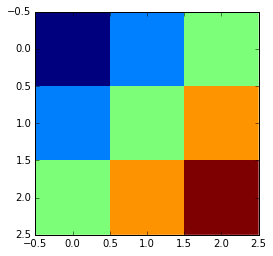

In [10]:
plt.imshow(np.array([[i + j for i in range(3)]
                     for j in range(3)]),
           interpolation='None'
           )

### Skipping certain output types

In case nbval is comparing some cell outputs you do not care about, like:

```Traceback:missing key: TESTING dict_keys(['stderr']) != REFERENCE dict_keys(['application/javascript', 'stderr'])```

There is a workaround. Add the following to your conftest.py:

In [1]:
def pytest_collectstart(collector):
    collector.skip_compare += 'text/html', 'application/javascript', 'stderr',